 Range of error for Majority Voting

In [1]:
from scipy.special import comb
import math

def ensemble_error(n_clf, err):
    k_start = int(math.ceil(n_clf/2.))
    probs = [comb(n_clf, k) * # binomial coeff
            err**k*
            (1-err)**(n_clf-k) 
             for k in range(k_start, n_clf +1)]
    return sum(probs)

In [2]:
ensemble_error(n_clf=11, err=0.25)

0.03432750701904297

Visualize errors for ensemble and individual classifiers

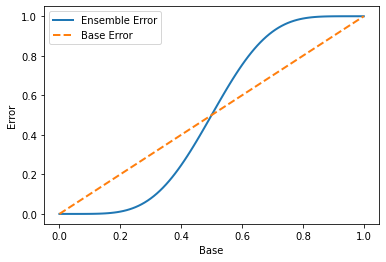

In [3]:
import numpy as np
import matplotlib.pyplot as plt

err_range = np.arange(0.0, 1.01, 0.01)
ens_errs = [ensemble_error(n_clf=11, err=error) for error in 
           err_range]

plt.plot(err_range, ens_errs, 
        label ='Ensemble Error',linewidth=2)
plt.plot(err_range, err_range, label='Base Error', linewidth=2, linestyle='--')
plt.ylabel("Error")
plt.xlabel("Base")
plt.legend()
plt.show()

In [4]:
# weighted classifiers
import numpy as np
np.argmax(np.bincount([0, 0, 1], 
                     weights=[0.2, 0.2, 0.6]))

1

In [5]:
ex = np.array([[0.9, 0.1],
             [0.8,0.2],
             [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2,0.2,0.6])
print(p)
print(np.argmax(p)) # label

[0.58 0.42]
0


# majority vote  classifier

In [6]:
# to obtain methods score, get_params, set_params for free
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin

from sklearn.preprocessing import LabelEncoder

from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier( BaseEstimator,
                            ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    
    def __init__(self, classifiers, vote ='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers ={key: value for
                                  key, value in
                                 _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')
            
        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict               
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit_transform(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
                fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
                self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability'    :
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else: # vote='classlabel'
            # obtain results from clf.predict
            predictions = np.asarray([clf.predict(X) for clf in
                                     self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                                            lambda x:
                                            np.argmax(np.bincount(x,
                                                     weights=self.weights)),
                axis=1, arr=predictions)  
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            
            
            
            
    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out
        
                                       
                
    



## Use Classifier

Load data set

In [7]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]

le = LabelEncoder()

Split data set

In [8]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, stratify=y, random_state=1,
                                         test_size=0.5)

 train KNN, decision tree, logistic regression
 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

clf1 = LogisticRegression(solver='lbfgs', penalty='l2',
                         random_state=1, C=0.001)
clf2 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

clf3 = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=0)

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
# KNN doesn't need scaling
clf_labels =['logistic regression', 'decision tree', ' KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_tr,
                             y=y_tr,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [logistic regression]
ROC AUC: 0.83 (+/- 0.15) [decision tree]
ROC AUC: 0.87 (+/- 0.18) [ KNN]


## Combine classifiers

In [10]:
major_vote_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels+=['Major voting']
all_clf = [pipe1,clf2, pipe3, major_vote_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_tr, y= y_tr, cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [logistic regression]
ROC AUC: 0.83 (+/- 0.15) [decision tree]
ROC AUC: 0.87 (+/- 0.18) [ KNN]
ROC AUC: 0.95 (+/- 0.11) [Major voting]


# Evaluating and tuning 

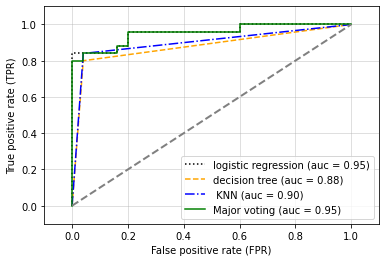

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 0
    y_pred = clf.fit(X_tr,
                     y_tr).predict_proba(X_ts)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_ts,
                                     y_score=y_pred,
                                    pos_label=2)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

Although it is not necessary, we scale data for KNN and logistic regression

In [12]:
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)

AttributeError: 'NoneType' object has no attribute 'reshape'

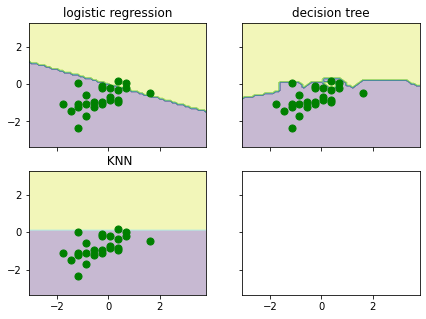

In [13]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, major_vote_clf]

x_min = X_tr_std[:, 0].min() - 1
x_max = X_tr_std[:, 0].max() + 1
y_min = X_tr_std[:, 1].min() - 1
y_max = X_tr_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_tr_std, y_tr)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    if clf == major_vote_clf:
        axarr[idx[0], idx[1]].scatter(X_tr_std[y_tr==1, 1], 
                                  X_tr_std[y_tr==1, 2], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
        axarr[idx[0], idx[1]].scatter(X_tr_std[y_tr==2, 1], 
                                  X_tr_std[y_tr==2, 2], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
        axarr[idx[0], idx[1]].set_title(tt)
    else:
            axarr[idx[0], idx[1]].scatter(X_tr_std[y_tr==0, 0], 
                                  X_tr_std[y_tr==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
            axarr[idx[0], idx[1]].scatter(X_tr_std[y_tr==1, 0], 
                                  X_tr_std[y_tr==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
            axarr[idx[0], idx[1]].set_title(tt)
        
    

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)


plt.show()

In [ ]:
major_vote_clf.get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV


params = {'pipeline-2__clf__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=major_vote_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_tr, y_tr)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

# Bagging


Upload data set

In [14]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
'machine-learning-databases/wine/wine.data',
header=None)

df_wine.columns = ['Class label','Alcohol','Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium',
                  'Total phenols ', 'Flavanoids',
                   'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                   'OD280/0D315 of diluted wines',
                   'Proline'
                  ]


df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/0D315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


 left out class 1

In [18]:
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/0D315 of diluted wines']].values

Preprocess


In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# encode labels
LE = LabelEncoder()
y = LE.fit_transform(y)

# split data set
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, stratify=y, random_state=1,
                                         test_size=0.2)

Create tree and bagging classifier


In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, n_jobs=2,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       random_state=1)

Evaluate performance via accuracy score

In [46]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_tr, y_tr)

y_tr_pred = tree.predict(X_tr)
y_ts_pred = tree.predict(X_ts)

tree_train = accuracy_score(y_tr, y_tr_pred)
tree_test = accuracy_score(y_ts, y_ts_pred)

print(f'Accuracy for training data set: {tree_train}\nAccuracy for test data set: {tree_test:.3}\n')

Accuracy for training data set: 1.0
Accuracy for test data set: 0.833



In [47]:
bag  = bag.fit(X_tr, y_tr)
y_tr_pred = bag.predict(X_tr)
y_ts_pred = bag.predict(X_ts)

In [48]:
bag_train = accuracy_score(y_tr, y_tr_pred)
bag_test = accuracy_score(y_ts, y_ts_pred)

print(f'Accuracy for training data set: {bag_train:.3}\nAccuracy for test data set: {bag_test:.3}\n')

Accuracy for training data set: 1.0
Accuracy for test data set: 0.917



Plot decision regions

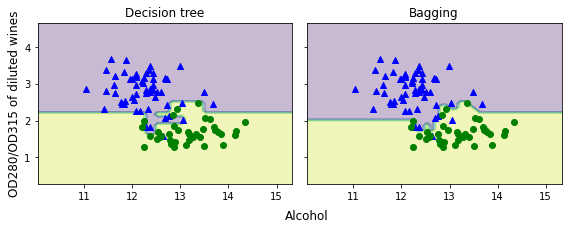

In [50]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_tr[:, 0].min() - 1
x_max = X_tr[:, 0].max() + 1
y_min = X_tr[:, 1].min() - 1
y_max = X_tr[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_tr, y_tr)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_tr[y_tr == 0, 0],
                       X_tr[y_tr == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_tr[y_tr == 1, 0],
                       X_tr[y_tr == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)


plt.show()

# AdaBoost

In [56]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(max_depth=1, 
                              random_state=1, criterion='entropy')
ada = AdaBoostClassifier(n_estimators=500, base_estimator = tree,
                        learning_rate=0.1,
                        random_state=1)

tree.fit(X_tr, y_tr)
y_tr_pred = tree.predict(X_tr)
y_ts_pred = tree.predict(X_ts)

tree_tr = accuracy_score(y_tr, y_tr_pred)
tree_ts = accuracy_score(y_ts, y_ts_pred)
print(f'Accuracy for training data set: {tree_tr:.3}\nAccuracy for test data set: {tree_ts:.3}\n')

Accuracy for training data set: 0.916
Accuracy for test data set: 0.875



Train AdaBoost and predict

In [57]:
ada.fit(X_tr, y_tr)
y_tr_pred = ada.predict(X_tr)
y_ts_pred = ada.predict(X_ts)

ada_tr = accuracy_score(y_tr, y_tr_pred)
ada_ts = accuracy_score(y_ts, y_ts_pred)
print(f'Accuracy for training data set: {ada_tr:.3}\nAccuracy for test data set: {ada_ts:.3}\n')

Accuracy for training data set: 1.0
Accuracy for test data set: 0.917



Plot decision regions

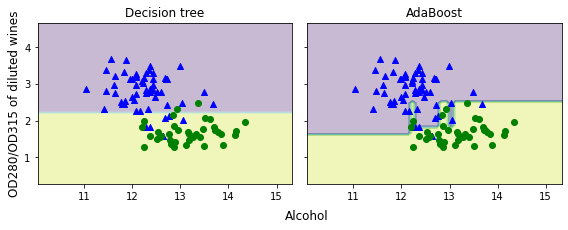

In [58]:
x_min, x_max = X_tr[:, 0].min() - 1, X_tr[:, 0].max() + 1
y_min, y_max = X_tr[:, 1].min() - 1, X_tr[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_tr, y_tr)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_tr[y_tr == 0, 0],
                       X_tr[y_tr == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_tr[y_tr == 1, 0],
                       X_tr[y_tr == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()


# Xgboost

In [64]:
%%bash 
conda install xgboost


Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [65]:
import xgboost as xgb

C:\Users\Anaconda\Miniconda3\envs\MLenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [69]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01,
                          max_depth=4, random_state=1,
                          use_label_encoder=False,
                         eval_metric='logloss')


gbm = model.fit(X_tr, y_tr)

y_train_pred = gbm.predict(X_tr)
y_test_pred = gbm.predict(X_ts)

gbm_train = accuracy_score(y_tr, y_train_pred) 
gbm_test = accuracy_score(y_ts, y_test_pred) 
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

XGboost train/test accuracies 0.968/0.917
